# Plotting factors against clinical variables

In [1]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 1) Load required packages
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
library(ggplot2)
library(gghalves)    # for geom_half_violin()
library(patchwork)   # for combining the three panels

## pT plot

In [2]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 1b) Load data
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
factor_scores <- read.csv("../../data/factor_scores.csv", stringsAsFactors = FALSE)

In [3]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 2) Define your color palette (same RGB values as in Python example)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
pal_rgb <- list(
  `Colon-no.`= c(127, 201, 127),
  pT1        = c(242, 240, 247),
  pT2        = c(203, 201, 226),
  pT3        = c(158, 154, 201),
  pT4        = c(106,  81, 163)
)

# Convert to hex
pal_stages <- sapply(pal_rgb, function(col) {
  sprintf("#%02x%02x%02x", col[1], col[2], col[3])
})

# Ensure the factor levels of Stage match the order you want
factor_scores$Stage <- factor(
  factor_scores$Stage,
  levels = c("Colon-no.", "pT1", "pT2", "pT3", "pT4")
)


In [4]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 3) Compute confidence ellipses (2‐SD) for each stage manually
#    We will build a data frame of ellipse points per stage, then plot via geom_path()
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
get_cov_ellipse_df <- function(x, y, nstd = 2, segments = 100) {
  # Calculate mean and covariance
  mu    <- c(mean(x), mean(y))
  cov_m <- cov(cbind(x, y))
  
  # Eigen‐decomposition
  eig    <- eigen(cov_m)
  vals   <- eig$values
  vecs   <- eig$vectors
  # Angle of the major axis (in degrees)
  angle  <- atan2(vecs[2,1], vecs[1,1]) * (180 / pi)
  # Width & height = 2 * (nstd * sqrt(eigenvalues))
  width  <- 2 * nstd * sqrt(vals[1])
  height <- 2 * nstd * sqrt(vals[2])
 
  # Parametric circle
  theta <- seq(0, 2*pi, length.out = segments)
  circle <- cbind(cos(theta), sin(theta))
  
  # Scale & rotate
  transform_mat <- vecs %*% diag(sqrt(vals)) * nstd
  coords <- t(transform_mat %*% t(circle)) + matrix(mu, nrow = segments, ncol = 2, byrow = TRUE)
  data.frame(x = coords[,1], y = coords[,2])
}

ellipse_df <- do.call(rbind, lapply(levels(factor_scores$Stage), function(stage) {
  df_s <- subset(factor_scores, Stage == stage)
  el   <- get_cov_ellipse_df(df_s$Factor.2, df_s$Factor.6, nstd = 2, segments = 200)
  el$Stage <- stage
  el
}))
rownames(ellipse_df) <- NULL


#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 4) Main scatter + ellipses plot (bottom‐left panel)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
x_range <- c(-1.5,2)
y_range <- c(-1.5,2)

xlabel <- paste0("Factor 2 (FWER = ", formatC(10 * kruskal.test(Factor.2 ~ Stage, data = factor_scores)$p.value, format="e", digits=2), ")")
ylabel <- paste0("Factor 6 (FWER = ", formatC(10 * kruskal.test(Factor.6 ~ Stage, data = factor_scores)$p.value, format="e", digits=2), ")")

p_main <- ggplot(factor_scores, aes(x = Factor.2, y = Factor.6, color = Stage)) +
  geom_point(alpha = 0.5) +
  geom_path(
    data       = ellipse_df,
    aes(x = x, y = y, group = Stage),
    color      = "black",
    linewidth  = 2.5,
    show.legend = FALSE
  ) +
  geom_path(
    data      = ellipse_df,
    aes(x = x, y = y, group = Stage, color = Stage),
    linewidth = 2
  ) +
  scale_color_manual(values = pal_stages) +
  coord_equal(xlim = x_range, ylim = y_range) +
  theme_classic(base_size = 16) +
  labs(x = xlabel, y = ylabel, color = "Stage") +
  theme(plot.margin = margin(0, 0, 0, 0)) +
  guides(color = "none")

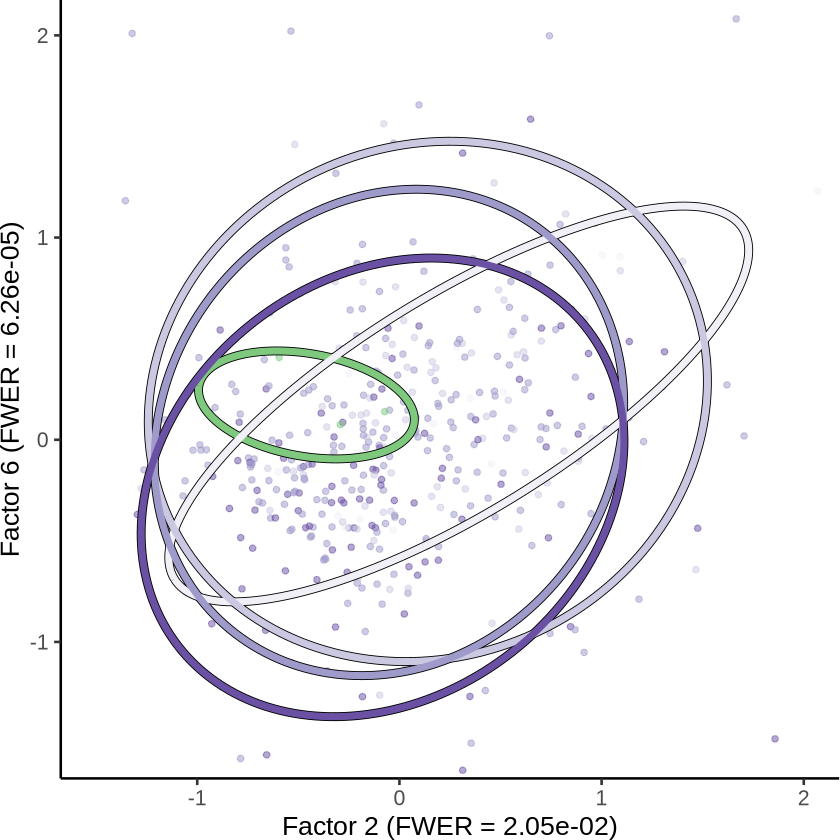

In [5]:
p_main

In [6]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 5) Top half‐violins of Factor4 by Stage (above p_main)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
p_top <- ggplot(factor_scores, aes(y = Factor.2, x = Stage, fill = Stage)) +
  geom_half_violin(
    side  = "r",
    scale = "width"
  ) +
  stat_summary(fun=median, geom='point', color='white', size=2) +
  coord_flip() +
  scale_fill_manual(values = pal_stages) +
  scale_y_continuous(limits = x_range) +
  theme_classic(base_size = 16) +
  labs(y = "", x = "Stage") +
  theme(
    plot.margin     = margin(0, 0, 0, 0)
  ) +
  guides(fill = "none")

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 6) Right half‐violins of Factor5 by Stage (beside p_main)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
p_right <- ggplot(factor_scores, aes(x = Stage, y = Factor.6, fill = Stage)) +
  geom_half_violin(
    side  = "r",
    scale = "width"
  ) +
  stat_summary(fun=median, geom='point', color='white', size=2) +
  scale_fill_manual(values = pal_stages) +
  scale_y_continuous(limits = y_range) +
  theme_classic(base_size = 16) +
  labs(x = "Stage", y = "") +
  theme(
    axis.text.x     = element_text(angle = 45, hjust = 1),
    plot.margin     = margin(0, 0, 0, 0)
  )

Warning message:
“Removed 4 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 4 rows containing non-finite outside the scale range
(`stat_summary()`).”


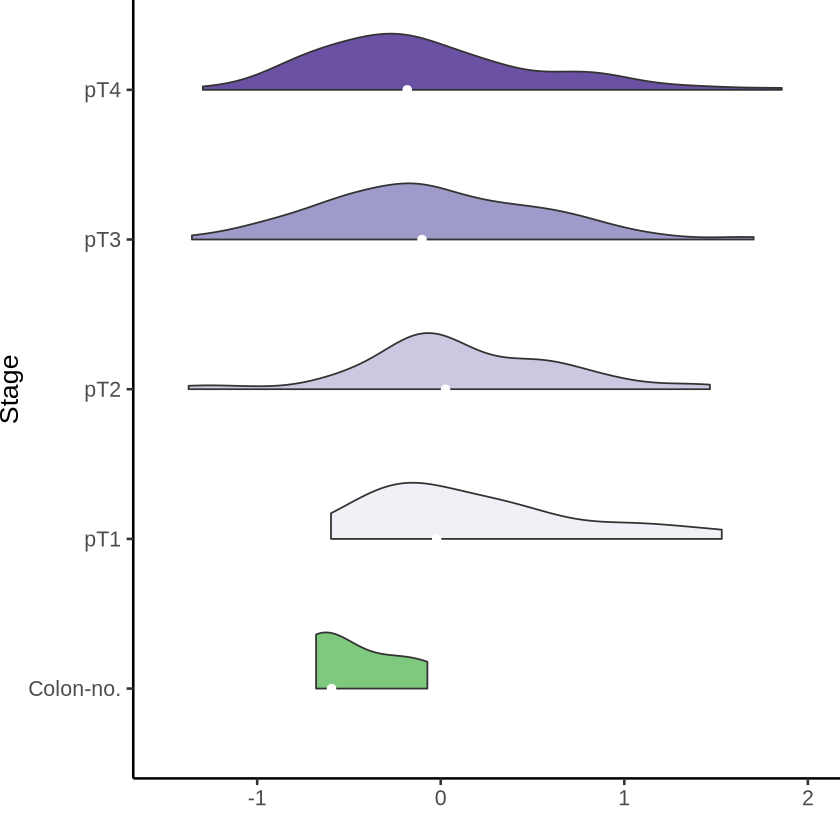

In [7]:
p_top

Warning message:
“Removed 11 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 11 rows containing non-finite outside the scale range
(`stat_summary()`).”


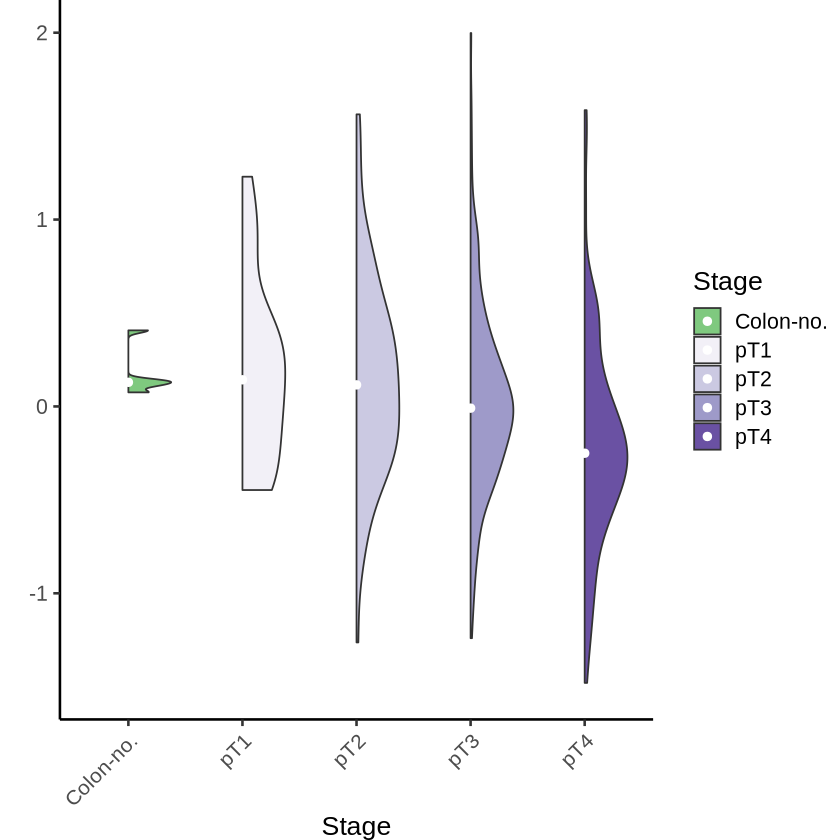

In [8]:
p_right

Warning message:
“Removed 4 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 4 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 11 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 11 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 4 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 4 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 11 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 11 rows containing non-finite outside the scale range
(`stat_summary()`).”


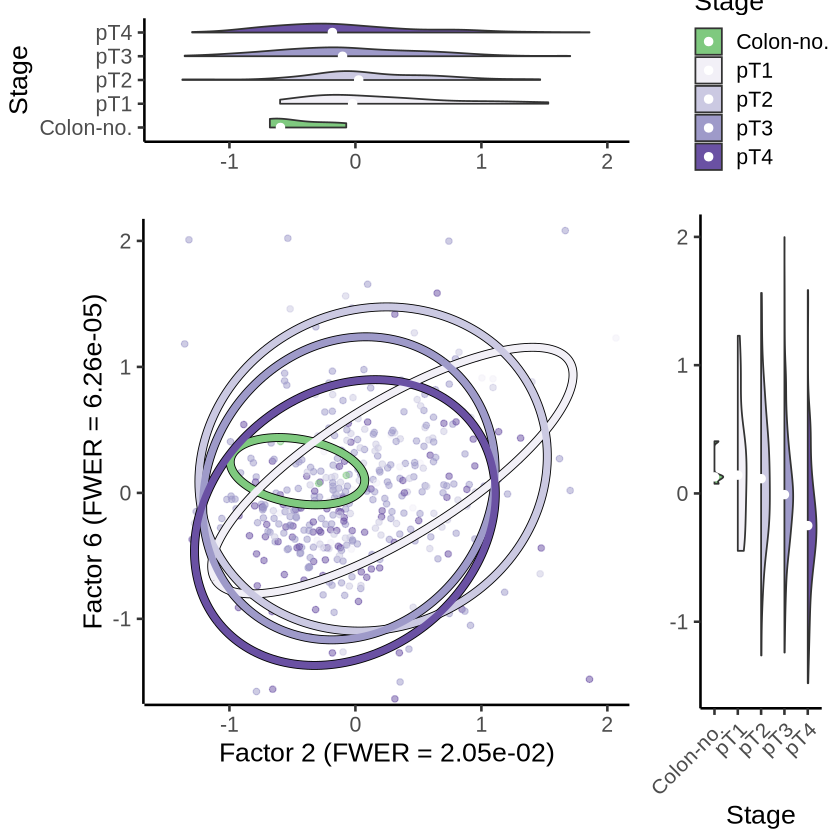

In [9]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 7) Combine with patchwork
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# Layout:   [ p_top  |   blank ] 
#           [ p_main | p_right ]
combined <- p_top + guide_area() + p_main + p_right +
  plot_layout(
    heights = c(1, 4),
    widths  = c(4, 1),
    guides  = "collect"
  )

# Display (or save with ggsave)
print(combined)

ggsave(combined, filename = "../../figures/fig5/pT_ellipses_with_margins.pdf",
       width = 8, height = 8)

## pN plot

In [10]:
factor_scores <- read.csv("../../data/pN_factor_scores.csv", stringsAsFactors = FALSE)

In [11]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 2) Define your color palette (same RGB values as in Python example)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
pal_rgb <- list(
  `Healthy`= c(127,201,127),
  pN0        = c(229,245,224),
  pN1        = c(161,217,155),
  pN2        = c(49,163,84)
)

# Convert to hex
pal_stages <- sapply(pal_rgb, function(col) {
  sprintf("#%02x%02x%02x", col[1], col[2], col[3])
})

# Ensure the factor levels of Stage match the order you want
factor_scores$Stage <- factor(
  factor_scores$Node,
  levels = c("Healthy", "pN0", "pN1", "pN2")
)


In [12]:
ellipse_df <- do.call(rbind, lapply(levels(factor_scores$Stage), function(stage) {
  df_s <- subset(factor_scores, Stage == stage)
  el   <- get_cov_ellipse_df(df_s$Factor.5, df_s$Factor.8, nstd = 2, segments = 200)
  el$Stage <- stage
  el
}))
rownames(ellipse_df) <- NULL


#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 4) Main scatter + ellipses plot (bottom‐left panel)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
x_range <- c(-1.5,1.5)
y_range <- c(-1.5,1.5)

xlabel <- paste0("Factor 5 (FWER = ", formatC(10 * kruskal.test(Factor.5 ~ Stage, data = factor_scores)$p.value, format="e", digits=2), ")")
ylabel <- paste0("Factor 8 (FWER = ", formatC(10 * kruskal.test(Factor.8 ~ Stage, data = factor_scores)$p.value, format="e", digits=2), ")")

p_main <- ggplot(factor_scores, aes(x = Factor.5, y = Factor.8, color = Stage)) +
  geom_point(alpha = 0.5) +
  geom_path(
    data       = ellipse_df,
    aes(x = x, y = y, group = Stage),
    color      = "black",
    linewidth  = 2.5,
    show.legend = FALSE
  ) +
  geom_path(
    data      = ellipse_df,
    aes(x = x, y = y, group = Stage, color = Stage),
    linewidth = 2
  ) +
  scale_color_manual(values = pal_stages) +
  coord_equal(xlim = x_range, ylim = y_range) +
  theme_classic(base_size = 16) +
  labs(x = xlabel, y = ylabel, color = "Stage") +
  theme(plot.margin = margin(0, 0, 0, 0)) +
  guides(color = "none")

In [13]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 5) Top half‐violins
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
p_top <- ggplot(factor_scores, aes(y = Factor.5, x = Stage, fill = Stage)) +
  geom_half_violin(
    side  = "r",
    scale = "width"
  ) +
  stat_summary(fun=median, geom='point', color='white', size=2) +
  coord_flip() +
  scale_fill_manual(values = pal_stages) +
  scale_y_continuous(limits = x_range) +
  theme_classic(base_size = 16) +
  labs(y = "", x = "Stage") +
  theme(
    plot.margin     = margin(0, 0, 0, 0)
  ) +
  guides(fill = "none")

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 6) Right half‐violins
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
p_right <- ggplot(factor_scores, aes(x = Stage, y = Factor.8, fill = Stage)) +
  geom_half_violin(
    side  = "r",
    scale = "width"
  ) +
  stat_summary(fun=median, geom='point', color='white', size=2) +
  scale_fill_manual(values = pal_stages) +
  scale_y_continuous(limits = y_range) +
  theme_classic(base_size = 16) +
  labs(x = "Stage", y = "") +
  theme(
    axis.text.x     = element_text(angle = 45, hjust = 1),
    plot.margin     = margin(0, 0, 0, 0)
  )

Warning message:
“Removed 14 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 14 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 14 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 14 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_summary()`).”


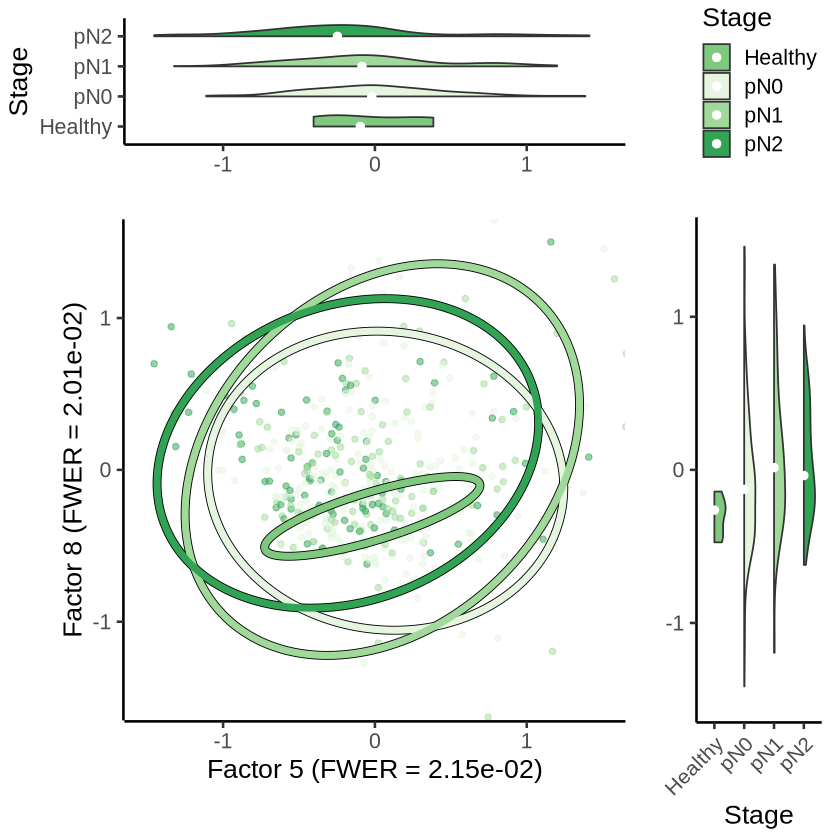

In [14]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 7) Combine with patchwork
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# Layout:   [ p_top  |   blank ] 
#           [ p_main | p_right ]
combined <- p_top + guide_area() + p_main + p_right +
  plot_layout(
    heights = c(1, 4),
    widths  = c(4, 1),
    guides  = "collect"
  )

# Display (or save with ggsave)
print(combined)

ggsave(combined, filename = "../../figures/fig5/pN_ellipses_with_margins.pdf",
       width = 8, height = 8)

## MSI plot

In [15]:
factor_scores <- read.csv("../../data/MSI_factor_scores.csv", stringsAsFactors = FALSE)

In [16]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 2) Define your color palette (same RGB values as in Python example)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
pal_rgb <- list(
  MSI = c(252,146,114),
  MSS = c(254,224,210)
)

# Convert to hex
pal_stages <- sapply(pal_rgb, function(col) {
  sprintf("#%02x%02x%02x", col[1], col[2], col[3])
})

# Ensure the factor levels of Stage match the order you want
factor_scores$Stage <- factor(
  factor_scores$MS,
  levels = c("MSI", "MSS")
)


In [17]:
ellipse_df <- do.call(rbind, lapply(levels(factor_scores$Stage), function(stage) {
  df_s <- subset(factor_scores, Stage == stage)
  el   <- get_cov_ellipse_df(df_s$Factor.9, df_s$Factor.3, nstd = 2, segments = 200)
  el$Stage <- stage
  el
}))
rownames(ellipse_df) <- NULL


#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 4) Main scatter + ellipses plot (bottom‐left panel)
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
y_range <- c(-1.5,1.5)
x_range <- c(-1.5,2.5)

xlabel <- paste0("Factor 9 (FWER = ", formatC(10 * kruskal.test(Factor.9 ~ Stage, data = factor_scores)$p.value, format="e", digits=2), ")")
ylabel <- paste0("Factor 3 (FWER = ", formatC(10 * kruskal.test(Factor.3 ~ Stage, data = factor_scores)$p.value, format="e", digits=2), ")")

p_main <- ggplot(factor_scores, aes(x = Factor.9, y = Factor.3, color = Stage)) +
  geom_point(alpha = 0.5) +
  geom_path(
    data       = ellipse_df,
    aes(x = x, y = y, group = Stage),
    color      = "black",
    linewidth  = 2.5,
    show.legend = FALSE
  ) +
  geom_path(
    data      = ellipse_df,
    aes(x = x, y = y, group = Stage, color = Stage),
    linewidth = 2
  ) +
  scale_color_manual(values = pal_stages) +
  coord_equal(xlim = x_range, ylim = y_range) +
  theme_classic(base_size = 16) +
  labs(x = xlabel, y = ylabel, color = "Stage") +
  theme(plot.margin = margin(0, 0, 0, 0)) +
  guides(color = "none")

In [18]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 5) Top half‐violins
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
p_top <- ggplot(factor_scores, aes(y = Factor.9, x = Stage, fill = Stage)) +
  geom_half_violin(
    side  = "r",
    scale = "width"
  ) +
  stat_summary(fun=median, geom='point', color='white', size=2) +
  coord_flip() +
  scale_fill_manual(values = pal_stages) +
  scale_y_continuous(limits = x_range) +
  theme_classic(base_size = 16) +
  labs(y = "", x = "Stage") +
  theme(
    plot.margin     = margin(0, 0, 0, 0)
  ) +
  guides(fill = "none")

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 6) Right half‐violins
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
p_right <- ggplot(factor_scores, aes(x = Stage, y = Factor.3, fill = Stage)) +
  geom_half_violin(
    side  = "r",
    scale = "width"
  ) +
  stat_summary(fun=median, geom='point', color='white', size=2) +
  scale_fill_manual(values = pal_stages) +
  scale_y_continuous(limits = y_range) +
  theme_classic(base_size = 16) +
  labs(x = "Stage", y = "") +
  theme(
    axis.text.x     = element_text(angle = 45, hjust = 1),
    plot.margin     = margin(0, 0, 0, 0)
  )

Warning message:
“Removed 1 row containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_summary()`).”


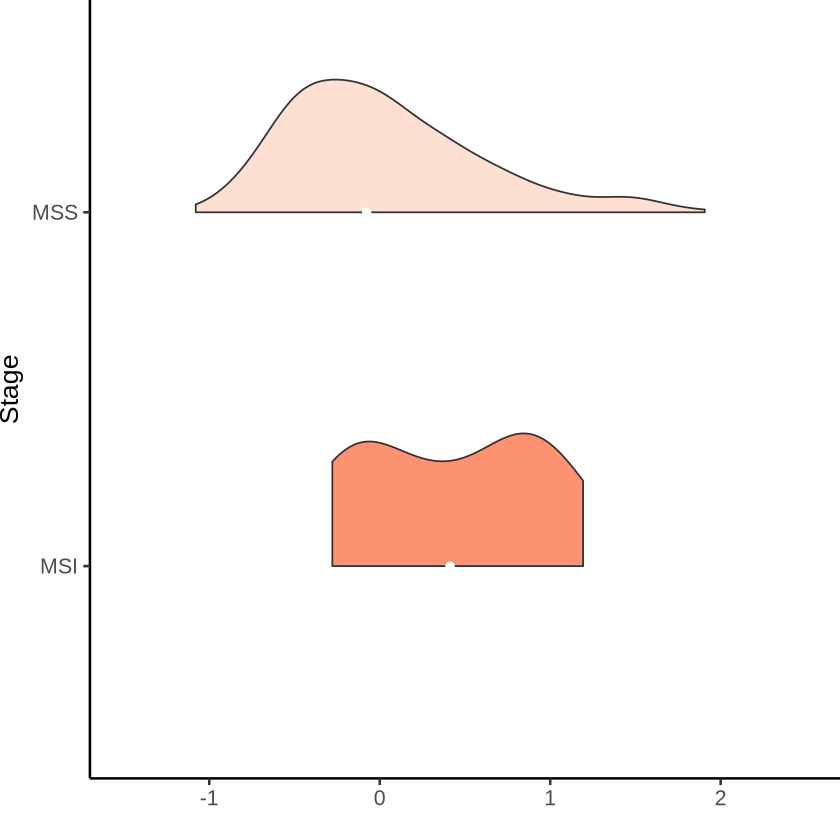

In [19]:
p_top 

Warning message:
“Removed 1 row containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_summary()`).”
Warning message:
“Removed 5 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 5 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_summary()`).”
Warning message:
“Removed 5 rows containing non-finite outside the scale range
(`stat_half_ydensity()`).”
Warning message:
“Removed 5 rows containing non-finite outside the scale range
(`stat_summary()`).”


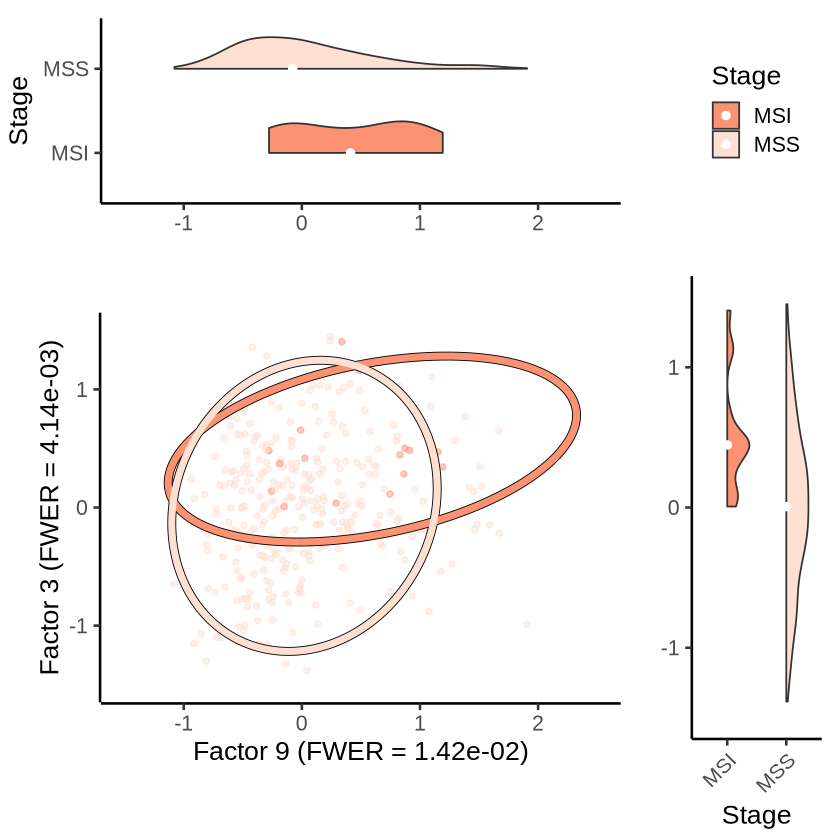

In [20]:
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# 7) Combine with patchwork
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# Layout:   [ p_top  |   blank ] 
#           [ p_main | p_right ]
combined <- p_top + guide_area() + p_main + p_right +
  plot_layout(
    heights = c(1, 2.5),
    widths  = c(4, 1),
    guides  = "collect"
  )

# Display (or save with ggsave)
print(combined)

ggsave(combined, filename = "../../figures/fig5/MSI_ellipses_with_margins.pdf",
       width = 8, height = 6.5)